YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.716080  72.776606  71.466820  71.721026  135480400
2020-01-03  72.009109  72.771737  71.783954  71.941321  146322800
2020-01-06  72.582893  72.621631  70.876060  71.127851  118387200
2020-01-07  72.241531  72.849208  72.021215  72.592578  108872000
2020-01-08  73.403648  73.706279  71.943759  71.943759  132079200


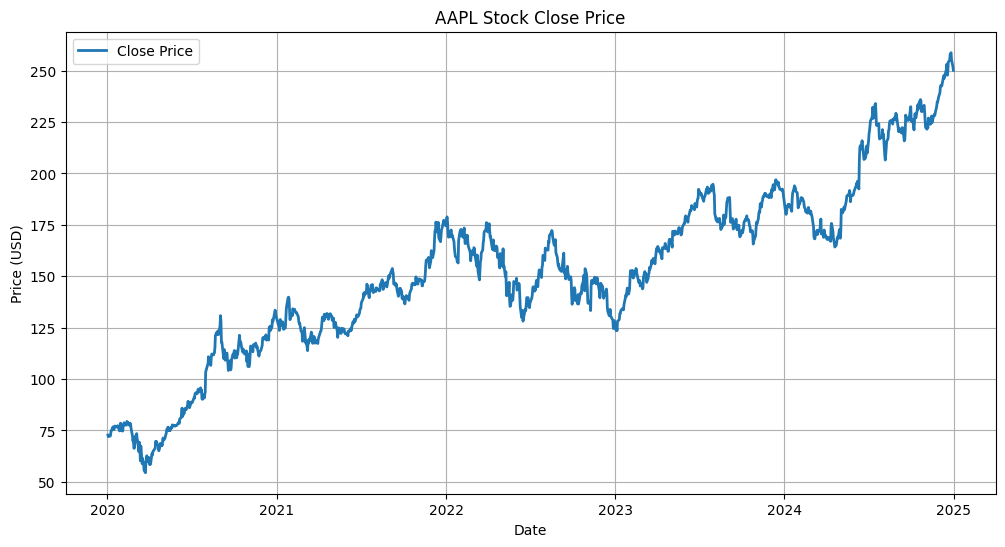

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt

# 종목 티커 설정 (예: 애플)
ticker = 'AAPL'

# 데이터 다운로드 (시작일과 종료일 설정)
data = yf.download(ticker, start='2020-01-01', end='2025-01-01')

# 다운로드한 데이터 확인 (데이터프레임 상위 5개 행 출력)
print(data.head())

# 종가(Close) 데이터를 시각화
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', linewidth=2)
plt.title(f'{ticker} Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size      # 상태의 차원
        self.action_size = action_size    # 가능한 행동의 수 (예: 3개: buy, sell, hold)
        self.memory = deque(maxlen=2000)    # 경험 재플레이 메모리
        self.gamma = 0.95                 # 할인율
        self.epsilon = 1.0                # 초기 탐험율
        self.epsilon_min = 0.01           # 최소 탐험율
        self.epsilon_decay = 0.995        # 탐험율 감소율
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # 간단한 다층 퍼셉트론(Multilayer Perceptron) 신경망 구성
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        # 경험을 메모리에 저장
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Epsilon-Greedy 정책: 무작위 탐험 또는 모델 기반 행동 선택
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        # 경험 재플레이를 통해 모델 학습
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                # Bellman Equation을 사용하여 target 계산
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target  # 선택된 행동의 Q-value 갱신
            self.model.fit(state, target_f, epochs=1, verbose=0)
        # 탐험율 감소
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [19]:
class TradingEnv:
    def __init__(self, data):
        self.data = data              # 예: yfinance로 불러온 주가 데이터 (Pandas DataFrame)
        self.current_step = 0
        self.total_steps = len(data) - 1
        self.initial_balance = 10000  # 초기 자산 (예시)
        self.balance = self.initial_balance
        self.position = 0             # 보유 주식 수 (0이면 미보유, 1이면 보유)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0
        return self._get_state()

    def _get_state(self):
        # 상태 정의: 예를 들어, [현재 종가, 이동평균, 보유 여부 등]
        # 아래 예제는 간단하게 현재 종가 하나만 사용
        state = np.array([self.data['Close'].iloc[self.current_step]])
        return np.reshape(state, [1, len(state)])

    def step(self, action):
        """
        행동: 0 = hold, 1 = buy, 2 = sell
        간단한 로직으로 보상 계산:
          - buy: 주식을 구매 (balance 감소, position 변화)
          - sell: 주식을 판매 (balance 증가, position 변화)
          - hold: 아무것도 하지 않음
        """
        done = False
        reward = 0
        price = self.data['Close'].iloc[self.current_step]

        # 행동에 따른 로직 처리 (여기서는 단순 예시)
        if action == 1:  # buy
            if self.position == 0:  # 아직 보유 중이 아니면 구매
                self.position = 1
                self.buy_price = price
        elif action == 2:  # sell
            if self.position == 1:  # 보유 중이면 판매
                profit = price - self.buy_price
                reward = profit  # 수익을 보상으로 설정
                self.balance += price  # 단순화된 거래: 실제 거래량 고려 X
                self.position = 0

        # 다음 단계로 진행
        self.current_step += 1
        if self.current_step >= self.total_steps:
            done = True
        next_state = self._get_state()
        return next_state, reward, done, {}


In [21]:
# 주가 데이터를 yfinance로 불러와서 DataFrame으로 준비했다고 가정합니다.
# 예시: data = yf.download("AAPL", start="2020-01-01", end="2021-01-01")
from tqdm import tqdm

state_size = 1        # 여기서는 단순히 종가만 사용 (실제 구현 시 기술 지표 등으로 확장)
action_size = 3       # 0: hold, 1: buy, 2: sell
agent = DQNAgent(state_size, action_size)
batch_size = 32
episodes = 50         # 학습 에피소드 수 (충분한 학습을 위해서는 에피소드 수를 늘려야 함)

env = TradingEnv(data)  # data는 yfinance로 불러온 DataFrame

for e in tqdm(range(episodes)):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-1-c447e0857353>:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  target_f[0][action] = target  # 선택된 행동의 Q-value 갱신
  0%|          | 0/50 [30:38<?, ?it/s]


KeyboardInterrupt: 